In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from AI.Features.Segmenting import deep_segment
#from AI.Features.SegmentingV2 import deep_segment
#from AI.Features.SegmentingV8 import deep_segment

from AI.Features.Segmenting import restore_mask
#from AI.Features.SegmentingV8 import restore_mask

from skimage import measure
import glob
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skimage import feature
import os

In [2]:
## Augmentation Function

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
def augm(lst, nm=5):
    # prepare iterator
    ls_gen=[]
    for arr in lst:

        data = arr
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.8,1],
                                     #rotation_range=50,
                                     width_shift_range=[0,.1],
                                     height_shift_range=[0,.1],
                                    #vertical_flip =True,
                                    #horizontal_flip=True
                                    ) 
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot

        for i in range(nm):
            # define subplot
            #pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            ls_gen.append(image)
    return lst+ls_gen

lymph= 5725
neut= 5860
MONO= 409
BASO= 85
EOSI= 596
[5725, 5860, 409, 85, 596]
12675


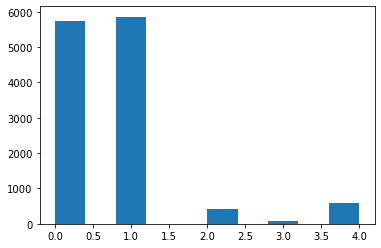

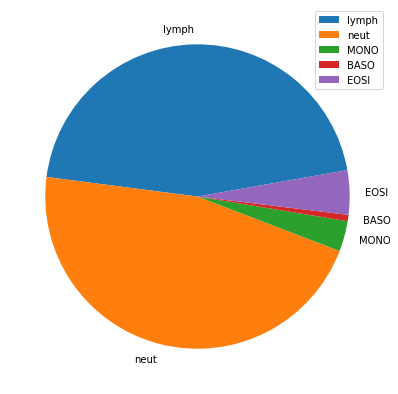

In [23]:
path1='./samples/Experiment/Training/*/*/'    
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO, nm=3)

ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [24]:
ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
sum_all=len(lymph)+len(neut)+len(MONO)+len(BASO)+len(EOSI)
print('lymph=',len(lymph),'        lymph_perc=',len(lymph)/sum_all)
print('neut=',len(neut),'          neut_perc=',len(neut)/sum_all)
print('MONO=',len(MONO),'          MONO_perc=',len(MONO)/sum_all)
print('BASO=',len(BASO),'          BASO_perc=',len(BASO)/sum_all)
print('EOSI=',len(EOSI),'          EOSI_perc=',len(EOSI)/sum_all)


lymph= 5725         lymph_perc= 0.4516765285996055
neut= 5860           neut_perc= 0.46232741617357004
MONO= 409           MONO_perc= 0.03226824457593688
BASO= 85           BASO_perc= 0.0067061143984220905
EOSI= 596           EOSI_perc= 0.04702169625246548


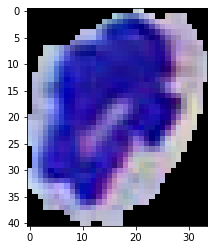

In [4]:
def get_nuc_and_cyt(segmented):
    nuc = (segmented==2).astype('uint8')
    cyt = (segmented==1).astype('uint8')
    #cyt,nuc=restore_mask(segmented)
    return cyt,nuc
     
def mask_cell(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(cyt)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell(neut[15])
plt.imshow(img)
plt.show()

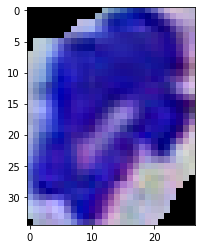

In [5]:
def mask_cell_nec(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(nuc)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell_nec(neut[15])
plt.imshow(img)
plt.show()

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

import cv2

# Load model into KerasLayer
#model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
#model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2" #.99
#model_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"          #97
model_url = ".\imagenet_efficientnet_v2_imagenet21k_s_feature_vector_2"
module = hub.KerasLayer(model_url)

"""
module = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
                   trainable=False),  # Can be True, see below.
    #tf.keras.layers.Dense(num_classes, activation='softmax')
])
module.build([None, 384, 384, 3])  # Batch input shape.
"""

'\nmodule = tf.keras.Sequential([\n    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",\n                   trainable=False),  # Can be True, see below.\n    #tf.keras.layers.Dense(num_classes, activation=\'softmax\')\n])\nmodule.build([None, 384, 384, 3])  # Batch input shape.\n'

In [7]:
def deepfeature(image):
    image = np.array(image)
    if len(image.shape)==2:
        backtorgb = cv2.cvtColor(np.array(image, dtype=np.uint8),cv2.COLOR_GRAY2RGB)
        image=backtorgb
        """
        image2=np.zeros((image.shape[0], image.shape[1],3),np.int32)
        image2[:,:,0]=image[:,:]
        image2[:,:,1]=image[:,:]
        image2[:,:,2]=image[:,:]
        image=image2
        """
    image=cv2.resize(image,(384,384))
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    logits=module(image)
    return np.array(logits)[0]
 
image=lymph[10]
logits =deepfeature(image) # module(preprocess_image(image))
logits.shape
 

(1280,)

In [8]:
#obj=LocalBinaryPatterns(points,8)

def features(c, f):
    if f==1:
        return all_together(c) 
    elif f==2:
        return obj.describe(mask_cell(c))
    elif f==3:
        return LBP_and_extent(c)
    elif f==4:
        return vggface3(c)
    elif f==5:
        return SOE_and_extent(c)
    elif f==6:
        return SOE_LBP_and_extent(c)
    elif f==7:
        return deepfeature(mask_cell_nec(c))#mask_cell(c))
    elif f==8:
        return SOE(c)
    elif f==9:
        return shape_features(c)
    elif f==10:
        return shapef_and_SOE(c)    
    elif f==11:
        return shapef_and_SOE_extent(c)    
    elif f==12:
        return shapef_and_SOE_extent_LBP(c)  
    elif f==13:
        return shapef_extent(c)  
    elif f==14:
        return GLCM(mask_cell(c))
    elif f==15:
        return shapef_GLCM(c)
    elif f==16:
        return shapef_GLCM_SOE(c)  
    elif f==17:
        return HOG_im(c)[0]    
    elif f==18:
        return shapef_GLCM_SOE_HOG(c)
    elif f==19:
        #PCA
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)  
    
    elif f==20:
        #lda
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)
    elif f==21:
        return shapef_GLCM_SOE_HOG_deep(c)
    elif f==22:
        return shapef_GLCM_SOE_deep(c)   

In [9]:

def alldata(cls,ft):

    if cls==2:
        lymph_extent = [ features(c, ft) for c in lymph]
        neut_extent = [features(c, ft) for c in neut]
        x = np.array(lymph_extent + neut_extent)#
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]

    
    elif cls==3:
        neut_extent = [features(c, ft) for c in neut]
        lymph_extent = [features(c, ft) for c in lymph]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(MONO_extent)*[2]
        
    elif cls==5:
        neut_extent = [features(c, ft)  for c  in neut]
        lymph_extent = [features(c, ft)  for c  in lymph]
        BASO_extent = [ features(c, ft)  for c  in BASO]
        EOSI_extent = [ features(c, ft)  for c in EOSI]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ BASO_extent+ EOSI_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(BASO_extent)*[2]+len(EOSI_extent)*[3]+len(MONO_extent)*[4]
        
    return x,y

In [10]:



def classif(cls,ft):
    print('#########################################################################################')
    print()
    print("classes=",cls,'   Features type=',ft)
    print()
    
    if ft==19:  pca = PCA(n_components=50)
    if ft==20:  lda = LinearDiscriminantAnalysis(n_components=4)
        
    x,y=alldata(cls,ft)
    
    print('training length=',len(x))
    print()
    print('#########################################################################################')    
    names = ["Decision Tree","Nearest Neighbors", "Neural Net", "AdaBoost", "SVM", "GaussianNB",
             "Random Forest"]

    classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),
                   KNeighborsClassifier(7),
                   MLPClassifier(alpha=.1, max_iter=10000),
                   AdaBoostClassifier(),
                   SVC(gamma=2, C=1),
                   GaussianNB(),
                   RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)
                   ]
    classifiers=[MLPClassifier(alpha=.1, max_iter=10000)]
    rkf=RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
    y1=np.array(y)
    for name, clf in zip(names, classifiers):
        list=[]
        list_tr=[]
        for train, test in rkf.split(x):
            #print("%s %s" % (train, test),"\n")
            #print(y1[train])
            X_train, X_test, y_train, y_test=x[train], x[test], y1[train], y1[test]
            
            if ft==19: #PCA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=pca.fit_transform(X_train)
                X_test= pca.transform(X_test)
                
            if ft==20: #LDA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=lda.fit_transform(X_train,y_train)
                X_test= lda.transform(X_test)
                
            clf.fit(X_train, y_train)
            predictions=clf.predict(X_test)
            #list.append(accuracy_score(y_test, predictions))
            list.append(f1_score(y_test, predictions,average='micro'))
            
            list_tr.append(accuracy_score(y_train, clf.predict(X_train)))

        print()
        print(name)
        #print(list_tr,"\n")
        print("Training Accuracy",end=" : ")
        print("\t",np.array(list_tr).mean(),"\t\terror +/-=",np.array(list_tr).std())

        #print(list,"\n")
        print("Test Accuracy",end=" : ")
        print("\t",np.array(list).mean(),"\t\terror +/-=",np.array(list).std())

In [ ]:
for cls in [2,3,5]: 
    for ft in [7]:#[1,2,3]:
        classif(cls,ft)

In [ ]:
##########################################################################################

lymph= 8308         lymph_perc= 0.42275595359250967
neut= 9738           neut_perc= 0.49552208426623245
MONO= 761           MONO_perc= 0.038723794015876244
BASO= 119           BASO_perc= 0.006055363321799308
EOSI= 726           EOSI_perc= 0.036942804803582335
[8308, 9738, 761, 119, 726]
19652


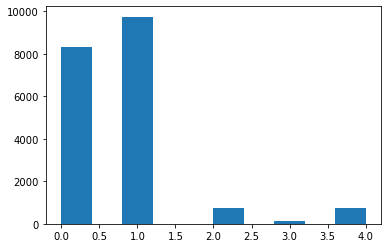

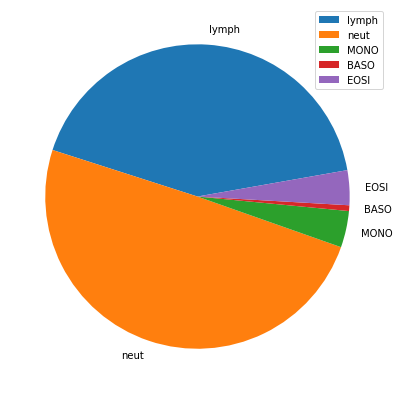

In [22]:
path1='./samples/Experiment4/*/*/*/'    
path2='.\samples\Experiment3\Train\\'
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO,nm=5)
from random import sample

#lymph=sample(lymph,8000)


ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
sum_all=len(lymph)+len(neut)+len(MONO)+len(BASO)+len(EOSI)
print('lymph=',len(lymph),'        lymph_perc=',len(lymph)/sum_all)
print('neut=',len(neut),'          neut_perc=',len(neut)/sum_all)
print('MONO=',len(MONO),'          MONO_perc=',len(MONO)/sum_all)
print('BASO=',len(BASO),'          BASO_perc=',len(BASO)/sum_all)
print('EOSI=',len(EOSI),'          EOSI_perc=',len(EOSI)/sum_all)

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [12]:
cl=5
fe=7

x,y=alldata(cl,fe)
X_train=x
y_train=y


No cell detected...........
No cell detected...........


In [13]:
X_train=x
y_train=y

In [14]:
dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
y_train=np.array([dic[x]  for x in y_train] )

#dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
#y_test=np.array([dic[x]  for x in y_test] )

In [15]:
class_weight = {0: 1,1: 1,2: 1,3:1, 4:1}

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))


#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile('sgd',loss='categorical_crossentropy', metrics=['accuracy'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train2, y_test = train_test_split(np.array(x), y_train, test_size = .01, random_state = 42)
#from sklearn.utils import shuffle
#X_train, y_train= shuffle(X_train, y_train)
model.fit(X_train, y_train2, epochs=100, batch_size=16,  validation_data =(X_test, y_test))#class_weight=class_weight)  validation_split=.1)#  

Epoch 1/100
1197/1197 [==============================] - 4s 3ms/step - loss: 0.6139 - accuracy: 0.8155 - val_loss: 0.1729 - val_accuracy: 0.9381
Epoch 2/100
1197/1197 [==============================] - 2s 1ms/step - loss: 0.3620 - accuracy: 0.8945 - val_loss: 0.1485 - val_accuracy: 0.9381
Epoch 3/100
1197/1197 [==============================] - 2s 2ms/step - loss: 0.3321 - accuracy: 0.8991 - val_loss: 0.1405 - val_accuracy: 0.9433
Epoch 4/100
1197/1197 [==============================] - 2s 2ms/step - loss: 0.3100 - accuracy: 0.9069 - val_loss: 0.1387 - val_accuracy: 0.9588
Epoch 5/100
1197/1197 [==============================] - 2s 2ms/step - loss: 0.3007 - accuracy: 0.9108 - val_loss: 0.1226 - val_accuracy: 0.9485
Epoch 6/100
1197/1197 [==============================] - 2s 2ms/step - loss: 0.2880 - accuracy: 0.9134 - val_loss: 0.1249 - val_accuracy: 0.9536
Epoch 7/100
1197/1197 [==============================] - 2s 2ms/step - loss: 0.2772 - accuracy: 0.9133 - val_loss: 0.1237 - val_ac

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19150, 1280), (194, 1280), (19344, 5), (194, 5))

In [17]:
train_nan=np.isnan(X_train).sum()
if train_nan!=0: X_train[np.isnan(X_train)] = 0
    
test_nan=np.isnan(X_test).sum()
if test_nan!=0: X_test[np.isnan(X_test)] = 0


#clf.fit(X_train, y_train)


#predictions=clf.predict(X_test)
predictions=model.predict(X_test)


In [18]:
predictions=predictions*[1,1,1,1,1]
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

0.9742268041237113


In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1) , target_names=["lymph","neut","BASO","EOSI","MONO"]))

              precision    recall  f1-score   support

       lymph       0.99      0.99      0.99        92
        neut       0.99      0.98      0.98        91
        BASO       0.00      0.00      0.00         1
        EOSI       0.62      1.00      0.77         5
        MONO       1.00      0.80      0.89         5

    accuracy                           0.97       194
   macro avg       0.72      0.75      0.73       194
weighted avg       0.97      0.97      0.97       194



C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[91,  1,  0,  0,  0],
       [ 0, 89,  0,  2,  0],
       [ 0,  0,  0,  1,  0],
       [ 0,  0,  0,  5,  0],
       [ 1,  0,  0,  0,  4]], dtype=int64)

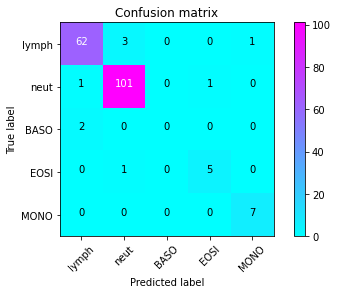

In [56]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), Y_pred.argmax(axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ["lymph","neut","BASO","EOSI","MONO"])#range(5)




In [57]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def con_mat(Threshold=1):
    predictions = model.predict_proba(X_test)*np.array([1,1,1,1,Threshold])
    predictions =predictions.argmax(axis=1)
    print(y_test[0])
    confusion_mtx = confusion_matrix(y_test.argmax(axis=1) , predictions)
    print(classification_report(y_test.argmax(axis=1), predictions , target_names=["lymph","neut","BASO","EOSI","MONO"]))
    plot_confusion_matrix(confusion_mtx, classes = ["lymph","neut","BASO","EOSI","MONO"])#range(5)


In [58]:

from ipywidgets import interactive, FloatSlider

interactive(lambda Threshold: con_mat(Threshold), Threshold=(0.0,10,.1))

interactive(children=(FloatSlider(value=5.0, description='Threshold', max=10.0), Output()), _dom_classes=('wid…

In [21]:
from keras.models import load_model

model.save('model_distribution5_1.h5')